In [118]:
import numpy as np
import pandas as pd
import os, pickle
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


from sklearn import metrics
import sklearn.preprocessing as preprocessing
import statistics
import math

import sklearn.linear_model as lm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist , pdist

from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings 
warnings.filterwarnings("ignore")


In [146]:
class DataPreparation:
    def __init__(self, outcome, features=None, categorical_features=None, one_hot_encoder=None):
        self._outcome = outcome
        self._features = features
        self._categorical_features = categorical_features
        self._one_hot_encoder = one_hot_encoder
 
    def getData(self, path, separator):
        data = pd.read_csv(path, sep = separator)
        if self._features:
            data = data[self._features]
        return data
    
    def replaceValues(self,colunas, data, tipo):
        if tipo == 'Binary':
            for coluna in colunas:
                coluna = data[coluna]
                for index in range (len(coluna)):
                    if coluna[index] >= 10:
                        coluna[index] = 1
                    else:
                        coluna[index] = 0
        elif tipo == 'FiveLevels':
            for coluna in colunas:
                coluna = data[coluna]
                for index in range (len(coluna)):
                    if coluna[index] <= 9:
                        coluna[index] = 5
                    elif coluna[index] >= 10 and coluna[index] <= 11 :
                        coluna[index] = 4
                    elif coluna[index] >= 12 and coluna[index] <= 13 :
                        coluna[index] = 3
                    elif coluna[index] >= 14 and coluna[index] <= 15 :
                        coluna[index] = 2
                    else:
                        coluna[index] = 1
        return data
    
    def getDataInfo(self,data):
        print("Number of Rows: {}\nNumber of Columns: {}".format(data.shape[0], data.shape[1]))
        print("The dataset has %d rows and %d columns " 
              % data.shape + "and has " + ("some" if data.isnull().values.any() else "no")  + " missing values.")
        return data.describe()
        
    def checkAndFillMissingValuesMode(self,data):
        features = data.columns
        for feature in features:
            if (data[feature].isnull().values.any() == True):
                print("-The column '{}', has'{}' missing values.\n"
                .format(feature, data[feature].isnull().sum()))
                data[feature].fillna(statistics.mode(data[feature]), inplace = True)
        return data
    
    def getFeaturesTypes(self,data):
        return(data.dtypes)
    
    def changeFeatureType(self,data,previousType, newType):
        for feature in data.columns:
            if ((data[feature].dtypes) == previousType):
                #for value in data[feature]:
                #value = value.astype(np.int64)
                data[feature] = data[feature].astype(np.int64)
        print(data.dtypes)
        return data

    def getBarPlots(self,data):
        plt.figure(figsize = (30, 30))
        for i in enumerate(data.columns):
            plt.subplot(int(data.columns.size/4)+1,4,i[0]+1)
            sns.countplot(i[1], data = data)
        
        
    def getCathegoricalFeatures(self,data):
        features = data.columns
        numeric_features = data._get_numeric_data().columns
        for column in data[numeric_features][:-2]:
            print("-The column '{}', has values that goes from '{}' to '{}' and is '{}' type.\n"
            .format(column, data[column].min(), data[column].max(), data[column].dtype))
            
        list_cathegorical_features = list(set(features) - set(numeric_features))
        for column in data[list_cathegorical_features][:-2]:
            print("-The column '{}' is a categorical column with values from '{}' to '{}' and is {} type"
          .format(column, data[column].min(), data[column].max(), data[column].dtype))
            
        return list_cathegorical_features
    
    def getFeaturesDescription(self,data, label):
        for col in data.columns:
            if col != label:
                data[col].describe()
    
    def CorrelationMatrix(self,data):
        plt.figure(figsize=(18,16))
        sns.heatmap(data.corr(),annot=True)
        plt.show()
        
    def Vif(self,data,label):
        thresh = 10
        independent_variables = []
        print(independent_variables)
        for col in data.columns:
            if col != label:
                independent_variables.append(col)
        for i in np.arange(0, len(data)):
            vif = [variance_inflation_factor(data[independent_variables].values,ix)
                for ix in range(data[independent_variables].shape[1])]
            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print('vif :', vif)
                print('dropping', data[independent_variables].columns[maxloc],
                      'at index', maxloc)
                del independent_variables[maxloc]
            else:
                break

        print('Final variables :',independent_variables)
        return independent_variables
    
    def oneHotEncoding(self, data):
        if self._categorical_features:
            categorial = data[self._categorical_features]
        else:
            categorical = data.select_dtypes(exclude=np.number)
            categorical_features = categorical.columns
        if self._one_hot_encoder:
            one_hot_encoder = self._one_hot_encoder
        else:
            one_hot_encoder = preprocessing.OneHotEncoder(
                sparse=False,
                drop='first')
        categorical = one_hot_encoder.fit_transform(categorical)
        categorical_columns = one_hot_encoder.get_feature_names_out(categorical_features)
        categorical = pd.DataFrame(categorical, columns=categorical_columns)
        continuous = data.select_dtypes(include=np.number)
        data = pd.concat([categorical, continuous], axis=1)
        return data, one_hot_encoder
    
    def normalizeData(self,data,label):
        numeric_features = data.loc[:, data.columns != label].select_dtypes(include=np.number).columns.tolist()
        numeric_features = ['age','Medu','Fedu','traveltime','studytime','failures','absences','famrel','freetime',
                            'goout','Dalc','Walc','health','G1','G2']

        sc = preprocessing.StandardScaler()
        sc.fit(data[numeric_features])
        data[numeric_features] = sc.transform(data[numeric_features])
        return data
    
    def splitData(self, data, independent_variables, size_test):
        x, y = data[independent_variables], data.iloc[:, [-1]]
        X_train , X_test , y_train , y_test = train_test_split(x, y, test_size = size_test, random_state = 2017)
        return X_train, X_test, y_train, y_test
    
    def fit(self, X_train, y_train, algorithm):
        model = algorithm.fit(X_train, y_train)
        return model
    
    def predict(self, model, X_test):
        result = model.predict(X_test)
        return result
    
    def modelMetrics(self,model, X_test, y_test, y_test_pred):
        print('Train MAE : ',metrics.mean_absolute_error(y_test,y_test_pred))
        print('Train RMSE',np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
        print('R- Squared = ',metrics.r2_score (y_test, y_test_pred))
        print("The MAE of the Model is:", metrics.mean_absolute_error(y_test, y_test_pred))
        print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
        print ('Test confusion matrix \n', metrics.confusion_matrix (y_test, y_test_pred))
        print ('Classification report : \n',metrics.classification_report(y_test,y_test_pred))

In [156]:
if __name__ == '__main__':
    path1 = 'Datasets\student-mat.csv'
    path2 = 'Datasets\student-por.csv'
    model_instance = DataPreparation(outcome = 'yes', features=None, categorical_features=None, one_hot_encoder=None)
    data_math = model_instance.getData(path1, separator = ';')
    data_math2 = model_instance.getData(path1, separator = ';')
    print(data_math)
    data_por = model_instance.getData(path2, separator = ';')
    data_por2 = model_instance.getData(path2, separator = ';')
    data_info_mat = model_instance.getDataInfo(data_math) 
    data_info_por = model_instance.getDataInfo(data_por)
    data_math = model_instance.checkAndFillMissingValuesMode(data_math)
    data_por = model_instance.checkAndFillMissingValuesMode(data_por)
    features_types_mat = model_instance.getFeaturesTypes(data_math)
    data_math = model_instance.changeFeatureType(data_math, 'float64', 'int64')
    dat_por = model_instance.changeFeatureType(data_por, 'float64', 'int64')
    data_math = model_instance.replaceValues(['G3'], data_math, tipo = 'Binary')
    dat_por = model_instance.replaceValues(['G3'], dat_por, tipo = 'Binary')
    
    """
    data_math = model_instance.normalizeData(data_math,'G3')
    dat_por = model_instance.normalizeData(dat_por,'G3')
    """
    
    data_math, one_hot_math = model_instance.oneHotEncoding(data_math)
    data_math = model_instance.normalizeData(data_math,'G3')
    data_math = data_math[data_math['G3']<=20]
    #independent_variables_math = model_instance.Vif(data_math,'G3')
    X_train_math, X_test_math, y_train_math, y_test_math = model_instance.splitData(data_math, 
                                                                     data_math.columns[data_math.columns != 'G3'], 
                                                                     size_test = 0.3)
    
    data_por, one_hot_por = model_instance.oneHotEncoding(data_por)
    data_por = model_instance.normalizeData(data_por,'G3')
    data_por = data_por[data_por['G3']<=20]

    #independent_variables_por = model_instance.Vif(data_por,'G3')
    X_train_por, X_test_por, y_train_por, y_test_por = model_instance.splitData(data_por, 
                                                                     data_por.columns[data_por.columns != 'G3'], 
                                                                     size_test = 0.3)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

In [149]:
print(data_math)

     school_MS  sex_M  address_U  famsize_LE3  Pstatus_T  Mjob_health  \
0          0.0    0.0        1.0          0.0        0.0          0.0   
1          0.0    0.0        1.0          0.0        1.0          0.0   
2          0.0    0.0        1.0          1.0        1.0          0.0   
3          0.0    0.0        1.0          0.0        1.0          1.0   
4          0.0    0.0        1.0          0.0        1.0          0.0   
..         ...    ...        ...          ...        ...          ...   
390        1.0    1.0        1.0          1.0        0.0          0.0   
391        1.0    1.0        1.0          1.0        1.0          0.0   
392        1.0    1.0        0.0          0.0        1.0          0.0   
393        1.0    1.0        0.0          1.0        1.0          0.0   
394        1.0    1.0        1.0          1.0        1.0          0.0   

     Mjob_other  Mjob_services  Mjob_teacher  Fjob_health  ...    famrel  \
0           0.0            0.0           0.0   

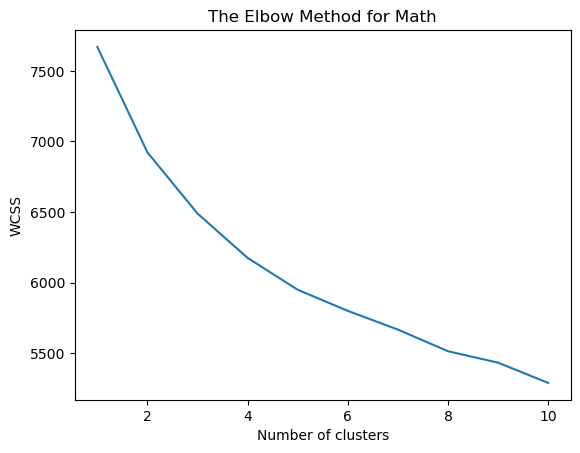

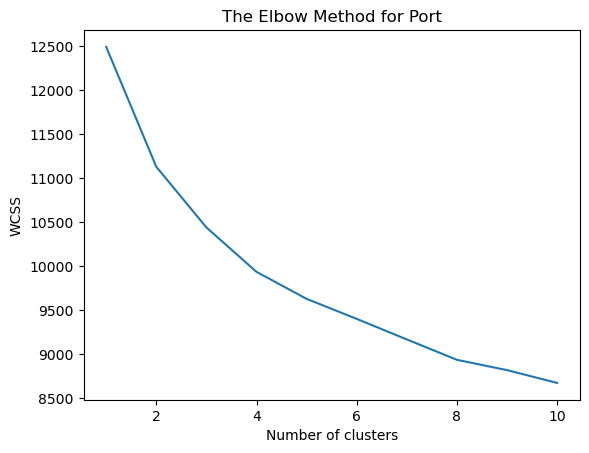

In [157]:
wcss_math = []
wcss_port = []
for i in range(1, 11):
    kmeans_math = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_port = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_math.fit(data_math)
    kmeans_port.fit(data_por)
    wcss_math.append(kmeans_math.inertia_)
    wcss_port.append(kmeans_port.inertia_)
plt.plot(range(1, 11), wcss_math)
plt.title('The Elbow Method for Math')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

plt.plot(range(1, 11), wcss_port)
plt.title('The Elbow Method for Port')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Accuracy score Math:  0.8126582278481013
Classification report:                precision    recall  f1-score   support

           0       0.64      0.99      0.78       131
           1       0.99      0.72      0.84       264

    accuracy                           0.81       395
   macro avg       0.82      0.86      0.81       395
weighted avg       0.88      0.81      0.82       395

Accuracy score Portuguese:  0.6194144838212635
Classification report:                precision    recall  f1-score   support

           0       0.29      1.00      0.45       100
           1       1.00      0.55      0.71       549

    accuracy                           0.62       649
   macro avg       0.64      0.78      0.58       649
weighted avg       0.89      0.62      0.67       649



Text(0.5, 1.0, 'Predicted grades Portuguese')

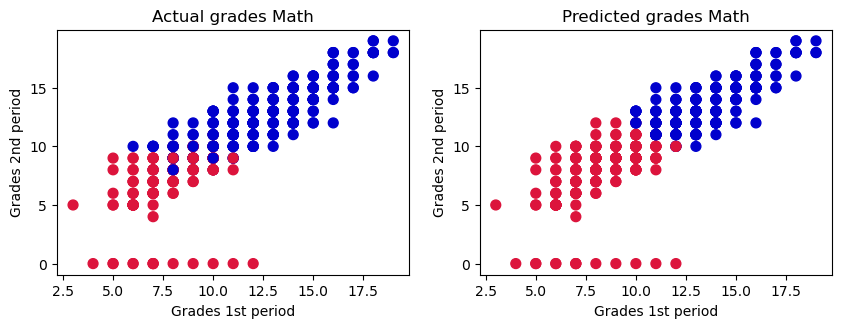

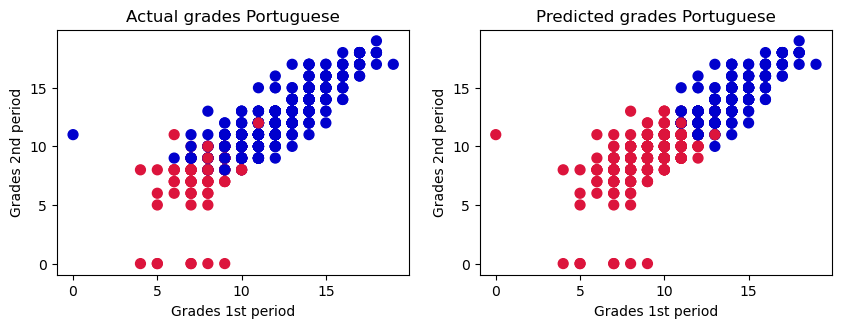

In [167]:

# Fitting K-Means to the dataset
kmeans_math = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans_math = kmeans_math.fit_predict(data_math[['absences', 'G1', 'G2']])

kmeans_port = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans_port = kmeans_port.fit_predict(data_por[['absences', 'G1', 'G2']])

kmeans_math.fit(data_math[['absences', 'G1', 'G2']])
kmeans_port.fit(data_por[['absences', 'G1', 'G2']])

labels_math = kmeans_math.labels_
labels_port = kmeans_port.labels_

#print(labels_math)
data_math['predict'] = np.choose(labels_math, [1,0]).astype(np.int64)
data_por['predict'] = np.choose(labels_port, [1,0]).astype(np.int64)

y_math = data_math['G3']
y_port = data_por['G3']

# check how many of the samples were correctly labeled

#correct_labels_math = sum(y_math == labels_math)
#correct_labels_port = sum(y_port == labels_port)
#print("Result: %d out of %d samples were correctly labeled." % (correct_labels, y.size))
#MATH
print('Accuracy score Math: ', metrics.accuracy_score(y_math, data_math.predict))
print('Classification report: ', metrics.classification_report(y_math, data_math.predict))

plt.figure(figsize = (10,7))

cmap = ListedColormap(["crimson", "mediumblue"])

plt.subplot (2, 2, 1)
plt.scatter(data_math2['G1'], data_math2['G2'], c=cmap(y_math), marker='o', s=50)
plt.xlabel('Grades 1st period')
plt.ylabel('Grades 2nd period')
plt.title('Actual grades Math')

plt.subplot (2, 2, 2)
plt.scatter(data_math2['G1'], data_math2['G2'], c=cmap(data_math.predict), marker='o', s=50)
plt.xlabel('Grades 1st period')
plt.ylabel('Grades 2nd period')
plt.title('Predicted grades Math')

#PORT
print('Accuracy score Portuguese: ', metrics.accuracy_score(y_port, data_por.predict))
print('Classification report: ', metrics.classification_report(y_port, data_por.predict))

plt.figure(figsize = (10,7))
plt.subplot (2, 2, 1)
plt.scatter(data_por2['G1'], data_por2['G2'], c=cmap(y_port), marker='o', s=50)
plt.xlabel('Grades 1st period')
plt.ylabel('Grades 2nd period')
plt.title('Actual grades Portuguese')

plt.subplot (2, 2, 2)
plt.scatter(data_por2['G1'], data_por2['G2'], c=cmap(data_por.predict), marker='o', s=50)
plt.xlabel('Grades 1st period')
plt.ylabel('Grades 2nd period')
plt.title('Predicted grades Portuguese')